In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# ============================================================
# ✅ FIX PATH FOR NOTEBOOK INSIDE /notebooks
# ============================================================
import sys, os
from pathlib import Path

# Xác định thư mục cha của notebooks/
project_root = Path(os.getcwd()).parent  # => C:\Users\User\RR_model
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))  # ⚠️ thêm project_root, KHÔNG thêm src

print("📁 Project root added:", project_root)

# Kiểm tra lại
import importlib.util
print("🔍 src module found:", importlib.util.find_spec("src"))

📁 Project root added: c:\Users\User\Projection_PB\Projection_pb
🔍 src module found: ModuleSpec(name='src', loader=<_frozen_importlib_external.SourceFileLoader object at 0x000002D7167AB6D0>, origin='c:\\Users\\User\\Projection_PB\\Projection_pb\\src\\__init__.py', submodule_search_locations=['c:\\Users\\User\\Projection_PB\\Projection_pb\\src'])


In [ ]:
# ===========================================================
# 📘 Roll Rate Demo v7 - Sử dụng dữ liệu thật từ Oracle hoặc SQL file
# ===========================================================

from pathlib import Path
import sys
import pandas as pd
import numpy as np

# --- 1️⃣ Setup đường dẫn và import các module ---
root = Path(".").resolve()
sys.path.append(str(root / "src"))

from src.data_loader import load_data
from src.config import CFG, OUT_ROOT
from src.rollrate.transition import compute_transition_from_pairs, compute_transition_by_mob

from src.rollrate.export_excel import export_transition_excel
try:
    from src.rollrate.backtest import (
        compute_actual_matrix,
        rollforward_validation,
        plot_matrix_diff,
        plot_distribution_compare
    )
except Exception as e:
    print("Backtest modules not loaded:", e)

print("✅ Import modules thành công.")
print("Cấu hình CFG:", CFG)


# --- 2️⃣ Load dữ liệu thực tế ---
#sql_path = r"C:/Users/MAFC4709/Python_work/RR_model_1911/sql/uns2.sql"

#df = load_data(sql_path)
#df = load_data('C:/Users/MAFC4709/Python_work/POS_Parquet_2/')
df = load_data('C:/Users/User/Projection_PB/Projection_pb/ETB_Parquet_YYYYMM')
#df = load_data('C:/Users/MAFC4709/Python_work/CASHLOAN_Parquet_2/')


df['DISBURSAL_DATE'] = df['DISBURSAL_DATE'].apply(lambda x: x.replace(day=1))

#print(f"📦 Đã load {len(df):,} dòng dữ liệu từ {sql_path}")

# Kiểm tra các cột quan trọng
required_cols = [CFG["loan"], CFG["mob"], CFG["state"], CFG["ead"], CFG["cutoff"]]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"❌ Thiếu các cột cần thiết trong data: {missing}")

print("✅ Dữ liệu có đủ các cột cần thiết:", required_cols)

# Nếu chưa có PRODUCT_TYPE thì thêm mặc định
if "PRODUCT_TYPE" not in df.columns:
    df["PRODUCT_TYPE"] = "A"
    print("⚠️ Không có PRODUCT_TYPE trong data, gán mặc định = 'A'")

# Convert cutoff về datetime
df[CFG["cutoff"]] = pd.to_datetime(df[CFG["cutoff"]])





✅ Import modules thành công.
Cấu hình CFG: {'loan': 'AGREEMENT_ID', 'mob': 'MOB', 'state': 'STATE_MODEL', 'orig_date': 'DISBURSAL_DATE', 'ead': 'PRINCIPLE_OUTSTANDING', 'disb': 'DISBURSAL_AMOUNT', 'cutoff': 'CUTOFF_DATE', 'ROLL_WINDOW': 20, 'DECAY_LAMBDA': 0.9659363289248456}
📦 Loading Parquet from: C:\Users\User\Projection_kiro\ETB_Parquet
✅ Loaded 6,065,817 rows via pyarrow.dataset from C:\Users\User\Projection_kiro\ETB_Parquet
ℹ️ Added default column PRODUCT_TYPE = 'A'
✅ Dữ liệu có đủ các cột cần thiết: ['AGREEMENT_ID', 'MOB', 'STATE_MODEL', 'PRINCIPLE_OUTSTANDING', 'CUTOFF_DATE']


# 0. Import & config chung

In [4]:
import pandas as pd
import numpy as np

from src.config import (
    CFG,
    BUCKETS_CANON,
    BUCKETS_30P,
    BUCKETS_60P,
    BUCKETS_90P,
)

from src.rollrate.transition import compute_transition_by_mob
from src.rollrate.lifecycle import (
    get_actual_all_vintages_amount,
    combine_all_lifecycle_amount,
    lifecycle_to_long_df_amount,
    tag_forecast_rows_amount,
    add_del_metrics,
    aggregate_to_product,
    aggregate_products_to_portfolio,
    export_lifecycle_all_products_one_file,
    extend_actual_info_with_portfolio,
)

from src.rollrate.calibration_kmob import (
    fit_k_raw,
    smooth_k,
    fit_alpha,
    forecast_all_vintages_partial_step,
    plot_k_curves,
    backtest_error_by_mob,
)


# 1. Đọc data loan-level & chuẩn hoá

In [5]:
#df_raw = df[df["PRODUCT_TYPE"] == "CDLPIL"].copy()
df_raw = df

In [ ]:
# 1.1. Load data loan level


# 1.2. (Tuỳ) Chuẩn hoá tên cột, kiểu dữ liệu nếu cần
df_raw["PRODUCT_TYPE"] = df_raw["PRODUCT_TYPE"].astype(str)
df_raw["RISK_SCORE"]   = df_raw["RISK_SCORE"].astype(str)
df_raw[CFG["orig_date"]] = pd.to_datetime(df_raw[CFG["orig_date"]])


# 2. Build transition matrices theo MOB

In [7]:
matrices_by_mob, parent_fallback = compute_transition_by_mob(df_raw)

# (Tuỳ) validate matrices:
# from src.rollrate.forecast import validate_matrices
# validate_matrices(matrices_by_mob)


⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=A, score=A)
⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=A, score=B)
⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=A, score=C)
⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=A, score=D)
⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=A, score=NA)
⚠️ Có 8 hàng có tổng weight = 0: ['DPD30+', 'DPD60+', 'DPD90+', 'DPD120+', 'DPD180+', 'PREPAY', 'WRITEOFF', 'SOLDOUT']
⚠️ Có 6 hàng có tổng weight = 0: ['DPD60+', 'DPD90+', 'DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚠️ Có 5 hàng có tổng weight = 0: ['DPD90+', 'DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREP

# 3. Lifecycle cho các khoản đã giải ngân (actual + forecast “gốc”)

In [8]:
max_mob = 36  # hoac 48, 60 tuy y

states = BUCKETS_CANON
s30_states = BUCKETS_30P

# Actual lifecycle by state (history)
actual_results = get_actual_all_vintages_amount(df_raw)

# Fit window: all vintages (set months to restrict)
FIT_MONTHS = None  # e.g., 6 or 12 to restrict
if FIT_MONTHS is None:
    df_fit = df_raw
else:
    fit_start = df_raw[CFG["orig_date"]].max() - pd.DateOffset(months=FIT_MONTHS)
    df_fit = df_raw[df_raw[CFG["orig_date"]] >= fit_start].copy()

actual_results_fit = get_actual_all_vintages_amount(df_fit)

# DISB_TOTAL map for fit window (cohort-based)
loan_disb_fit = (
    df_fit.groupby(["PRODUCT_TYPE", "RISK_SCORE", CFG["orig_date"], CFG["loan"]])[CFG["disb"]]
    .first()
)
cohort_disb_fit = loan_disb_fit.groupby(level=[0, 1, 2]).sum()
disb_total_by_vintage_fit = cohort_disb_fit.to_dict()


# 4. Fit k theo one-step DEL30 (partial-step overlay)

In [9]:
k_raw_by_mob, weight_by_mob, k_raw_df = fit_k_raw(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    include_co=True,
    denom_mode="disb",
    disb_total_by_vintage=disb_total_by_vintage_fit,
    min_disb=1e-10,
    weight_mode="equal",
    method="wls",
    eps=1e-8,
    min_denom=1e-10,
    min_obs=5,
    fallback_k=1.0,
    fallback_weight=0.0,
    return_detail=True,
)

print("k_raw_by_mob:", k_raw_by_mob)

if not k_raw_df.empty:
    def _wls_summary(g):
        denom = np.sum(g["weight"] * (g["a"] ** 2))
        numer = np.sum(g["weight"] * g["a"] * g["d"])
        k_wls = k_raw_by_mob.get(int(g.name), np.nan)
        return pd.Series({
            "n_obs": int(g.shape[0]),
            "w_sum": g["weight"].sum(),
            "denom_wls": denom,
            "numer_wls": numer,
            "k_wls": k_wls,
        })

    k_raw_summary = k_raw_df.groupby("mob").apply(_wls_summary).reset_index()
    k_raw_summary

if k_raw_by_mob:
    mob_min = min(k_raw_by_mob.keys())
    mob_max = max(k_raw_by_mob.keys())
else:
    mob_min, mob_max = 0, 0

k_smooth_by_mob, mobs, _ = smooth_k(
    k_raw_by_mob=k_raw_by_mob,
    weight_by_mob=weight_by_mob,
    mob_min=mob_min,
    mob_max=mob_max,
    gamma=10.0,
    monotone=False,
    use_cvxpy=True,
    default_k=1.0,
)

ALPHA_TARGET_MOB = min(max_mob, mob_max) if mob_max else max_mob
alpha, k_final_by_mob, alpha_scores = fit_alpha(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    k_smooth_by_mob=k_smooth_by_mob,
    mob_target=ALPHA_TARGET_MOB,
    include_co=True,
    alpha_grid=None,
    val_frac=0.2,
)

print("alpha:", alpha)
print("k_final_by_mob:", k_final_by_mob)


k_raw_by_mob: {0: 0.8405650584461072, 1: 0.9793287952928689, 2: 1.0, 3: 1.0, 4: 1.0, 5: 0.9393716166371727, 6: 0.9217784486007641, 7: 1.0, 8: 1.0, 9: 0.1687494527641365, 10: 1.0, 11: 1.0, 12: 1.0, 13: 0.7842324145478357, 14: 0.061092001992357536, 15: 1.0, 16: 0.8611936323463987, 17: 0.9019872512887643, 18: 0.8719868395535458, 19: 0.7952920964577564, 20: 0.7457294710120091, 21: 1.0, 22: 1.0, 23: 0.6967445940948426}
alpha: 1.0
k_final_by_mob: {0: 0.8473092541445064, 1: 0.9681670439006901, 2: 1.0, 3: 1.0, 4: 0.9914570966621339, 5: 0.9444335486370358, 6: 0.9408948520841867, 7: 0.9964913881973559, 8: 0.876444019098576, 9: 0.3905436064595008, 10: 0.8683310476711168, 11: 1.0, 12: 0.9767765631944579, 13: 0.6973594606896432, 14: 0.3043000294264513, 15: 0.8175671527654826, 16: 0.8980055485801922, 17: 0.9030597579971181, 18: 0.8625140241452628, 19: 0.7971172251243062, 20: 0.8024414657278939, 21: 0.9603722499215185, 22: 0.9558268524769594, 23: 0.7353034320805161}


C:\Users\User\AppData\Local\Temp\ipykernel_1112\3181303332.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  k_raw_summary = k_raw_df.groupby("mob").apply(_wls_summary).reset_index()


In [10]:
# WLS with regularization (k_prior=0 to bias k downward)
LAMBDA_K = 1e-4
K_PRIOR = 0.0

k_raw_reg_by_mob, weight_reg_by_mob, k_raw_reg_df = fit_k_raw(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    include_co=True,
    denom_mode="disb",
    disb_total_by_vintage=disb_total_by_vintage_fit,
    min_disb=1e-10,
    weight_mode="equal",
    method="wls_reg",
    lambda_k=LAMBDA_K,
    k_prior=K_PRIOR,
    eps=1e-8,
    min_denom=1e-10,
    min_obs=5,
    fallback_k=1.0,
    fallback_weight=0.0,
    return_detail=True,
)

print('k_raw_reg_by_mob:', k_raw_reg_by_mob)

mobs = sorted(set(k_raw_by_mob) | set(k_raw_reg_by_mob))
df_k_compare = pd.DataFrame({
    'mob': mobs,
    'k_wls': [k_raw_by_mob.get(m, np.nan) for m in mobs],
    'k_wls_reg': [k_raw_reg_by_mob.get(m, np.nan) for m in mobs],
})
df_k_compare['delta'] = df_k_compare['k_wls_reg'] - df_k_compare['k_wls']
display(df_k_compare)


k_raw_reg_by_mob: {0: 0.6387325115640561, 1: 0.9767000978367067, 2: 1.0, 3: 1.0, 4: 1.0, 5: 0.9372569946194887, 6: 0.9197880987514515, 7: 1.0, 8: 1.0, 9: 0.16860843707287784, 10: 1.0, 11: 1.0, 12: 1.0, 13: 0.7769472703260858, 14: 0.061040878570248355, 15: 1.0, 16: 0.8495655562058103, 17: 0.8886102294270501, 18: 0.8551919645058185, 19: 0.7655104670537441, 20: 0.7036564496216228, 21: 1.0, 22: 1.0, 23: 0.6137752771577148}


,mob,k_wls,k_wls_reg,delta
0,0,0.840565,0.638733,-0.201833
1,1,0.979329,0.976700,-0.002629
2,2,1.000000,1.000000,0.000000
3,3,1.000000,1.000000,0.000000
4,4,1.000000,1.000000,0.000000
5,5,0.939372,0.937257,-0.002115
6,6,0.921778,0.919788,-0.001990
7,7,1.000000,1.000000,0.000000
8,8,1.000000,1.000000,0.000000
9,9,0.168749,0.168608,-0.000141


In [11]:
# Smooth + alpha for regularized k
if k_raw_reg_by_mob:
    mob_min_reg = min(k_raw_reg_by_mob.keys())
    mob_max_reg = max(k_raw_reg_by_mob.keys())
else:
    mob_min_reg, mob_max_reg = 0, 0

k_smooth_reg_by_mob, mobs_reg, _ = smooth_k(
    k_raw_by_mob=k_raw_reg_by_mob,
    weight_by_mob=weight_reg_by_mob,
    mob_min=mob_min_reg,
    mob_max=mob_max_reg,
    gamma=10.0,
    monotone=False,
    use_cvxpy=True,
    default_k=1.0,
)

ALPHA_TARGET_MOB_REG = min(max_mob, mob_max_reg) if mob_max_reg else max_mob
alpha_reg, k_final_reg_by_mob, alpha_scores_reg = fit_alpha(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    k_smooth_by_mob=k_smooth_reg_by_mob,
    mob_target=ALPHA_TARGET_MOB_REG,
    include_co=True,
    alpha_grid=None,
    val_frac=0.2,
)

print('alpha_reg:', alpha_reg)
print('k_final_reg_by_mob:', k_final_reg_by_mob)


alpha_reg: 1.0
k_final_reg_by_mob: {0: 0.6564521318342907, 1: 0.9451753456183943, 2: 1.0, 3: 1.0, 4: 0.9911585732084373, 5: 0.9425581099309376, 6: 0.9390934375326371, 7: 0.996214231418483, 8: 0.8764654832172535, 9: 0.39048161921437, 10: 0.8683820287677425, 11: 1.0, 12: 0.9756198987459568, 13: 0.6923462250456682, 14: 0.30327883695177693, 15: 0.8159898726777478, 16: 0.8883357196563235, 17: 0.8894416733901449, 18: 0.8433449447019409, 19: 0.7670732278871404, 20: 0.7712345821840447, 21: 0.9547204745484184, 22: 0.943392215536421, 23: 0.6619932389102279}


In [12]:
# Debug WLS details per MOB (numerator/denominator, fallback, clipping)
MIN_OBS = 5
MIN_DENOM = 1e-10
EPS = 1e-8

df = k_raw_df.copy()
if df.empty:
    print("k_raw_df empty -> no data to fit.")
else:
    required = {"mob", "weight", "a", "d"}
    missing = required - set(df.columns)
    if missing:
        print("Missing columns:", missing)
    
    df["w_a2"] = df["weight"] * (df["a"] ** 2)
    df["w_ad"] = df["weight"] * df["a"] * df["d"]
    df["k_ratio"] = np.where(df["a"].abs() < EPS, np.nan, df["d"] / df["a"])

    def _agg(g):
        denom = g["w_a2"].sum()
        numer = g["w_ad"].sum()
        k_raw = numer / denom if denom != 0 else np.nan
        return pd.Series({
            "n_obs": int(g.shape[0]),
            "w_sum": g["weight"].sum(),
            "denom_wls": denom,
            "numer_wls": numer,
            "k_wls_raw": k_raw,
            "k_wls_clipped": np.clip(k_raw, 0, 1) if np.isfinite(k_raw) else np.nan,
            "pct_a_small": (g["a"].abs() < EPS).mean(),
            "pct_k_ratio_gt1": (g["k_ratio"] > 1).mean(),
            "pct_k_ratio_lt0": (g["k_ratio"] < 0).mean(),
            "a_min": g["a"].min(),
            "a_max": g["a"].max(),
            "d_min": g["d"].min(),
            "d_max": g["d"].max(),
        })

    summary = df.groupby("mob").apply(_agg).reset_index()
    summary["wls_used"] = (summary["n_obs"] >= MIN_OBS) & (summary["denom_wls"] >= MIN_DENOM)
    summary["k_from_func"] = summary["mob"].map(k_raw_by_mob)
    summary["is_fallback"] = ~summary["wls_used"]

    display(summary.sort_values("mob"))

    # Inspect a MOB where k is 1 or fallback, if available
    pick = summary[summary["k_from_func"] >= 0.999]
    if pick.empty:
        pick = summary[summary["is_fallback"]]
    if pick.empty:
        mob_to_inspect = summary["mob"].iloc[0]
    else:
        mob_to_inspect = pick["mob"].iloc[0]

    detail = df[df["mob"] == mob_to_inspect].copy()
    detail = detail.sort_values("weight", ascending=False)
    display(detail[["mob", "weight", "a", "d", "k_ratio", "w_a2", "w_ad"]].head(50))


C:\Users\User\AppData\Local\Temp\ipykernel_1112\1446538653.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df.groupby("mob").apply(_agg).reset_index()


,mob,n_obs,w_sum,denom_wls,numer_wls,k_wls_raw,k_wls_clipped,pct_a_small,pct_k_ratio_gt1,pct_k_ratio_lt0,a_min,a_max,d_min,d_max,wls_used,k_from_func,is_fallback
0,0,132.0,132.0,0.000316,0.000266,0.840565,0.840565,0.212121,0.325758,0.000000,0.000000,0.007084,0.000000,0.005999,True,0.840565,False
1,1,131.0,131.0,0.037155,0.036387,0.979329,0.979329,0.114504,0.335878,0.000000,0.000000,0.047239,0.000000,0.074475,True,0.979329,False
2,2,131.0,131.0,0.088410,0.108923,1.232030,1.000000,0.099237,0.389313,0.000000,0.000000,0.193392,0.000000,0.308550,True,1.000000,False
3,3,131.0,131.0,0.242622,0.335733,1.383771,1.000000,0.083969,0.358779,0.000000,-0.011255,0.416476,0.000000,0.664474,True,1.000000,False
4,4,131.0,131.0,0.084500,0.094379,1.116910,1.000000,0.091603,0.427481,0.000000,-0.065794,0.172208,0.000000,0.274752,True,1.000000,False
5,5,131.0,131.0,0.044323,0.041635,0.939372,0.939372,0.099237,0.450382,0.000000,-0.027205,0.047977,0.000000,0.038289,True,0.939372,False
6,6,131.0,131.0,0.046212,0.042598,0.921778,0.921778,0.099237,0.358779,0.015267,-0.005903,0.046811,-0.001050,0.038776,True,0.921778,False
7,7,127.0,127.0,0.166260,0.232744,1.399882,1.000000,0.094488,0.409449,0.000000,0.000000,0.355575,0.000000,0.567310,True,1.000000,False
8,8,123.0,123.0,0.124063,0.166780,1.344321,1.000000,0.089431,0.430894,0.008130,-0.056173,0.298464,-0.001177,0.476190,True,1.000000,False
9,9,119.0,119.0,0.119567,0.020177,0.168749,0.168749,0.092437,0.428571,0.008403,-0.012189,0.313388,-0.001303,0.028919,True,0.168749,False


,mob,weight,a,d,k_ratio,w_a2,w_ad
78,2,1.0,0.008356,0.009403,1.125286,0.000070,0.000079
101,2,1.0,0.007566,0.005784,0.764566,0.000057,0.000044
125,2,1.0,0.007747,0.007915,1.021639,0.000060,0.000061
149,2,1.0,0.004321,0.005593,1.294471,0.000019,0.000024
173,2,1.0,0.004444,0.006074,1.366916,0.000020,0.000027
197,2,1.0,0.006596,0.008261,1.252437,0.000044,0.000054
221,2,1.0,0.002172,0.002448,1.127188,0.000005,0.000005
245,2,1.0,0.002926,0.000954,0.325996,0.000009,0.000003
269,2,1.0,0.004540,0.000968,0.213194,0.000021,0.000004
292,2,1.0,0.010095,0.002713,0.268751,0.000102,0.000027


In [13]:
# Comparison table: Markov vs Actual DEL30 per MOB (weighted)
df = k_raw_df.copy()
req_cols = {"mob", "weight", "y_vm", "y_hat", "y_tar", "a", "d"}
if df.empty:
    print("k_raw_df empty -> no data to compare.")
elif not req_cols.issubset(df.columns):
    print("Missing columns:", req_cols - set(df.columns))
else:
    df["k_ratio"] = np.where(df["a"].abs() < EPS, np.nan, df["d"] / df["a"])

    def _wavg(s, w):
        total = w.sum()
        return float(np.average(s, weights=w)) if total > 0 else np.nan

    def _agg(g):
        w = g["weight"]
        y_vm = _wavg(g["y_vm"], w)
        y_hat = _wavg(g["y_hat"], w)
        y_tar = _wavg(g["y_tar"], w)
        denom = float(np.sum(w * (g["a"] ** 2)))
        numer = float(np.sum(w * g["a"] * g["d"]))
        return pd.Series({
            "n_obs": int(g.shape[0]),
            "w_sum": float(w.sum()),
            "y_vm_wavg": y_vm,
            "y_hat_wavg": y_hat,
            "y_tar_wavg": y_tar,
            "a_wavg": _wavg(g["a"], w),
            "d_wavg": _wavg(g["d"], w),
            "gap_hat_minus_tar": y_hat - y_tar if np.isfinite(y_hat) and np.isfinite(y_tar) else np.nan,
            "k_wls_raw": numer / denom if denom != 0 else np.nan,
            "k_ratio_wavg": _wavg(g["k_ratio"], w),
        })

    compare_by_mob = df.groupby("mob").apply(_agg).reset_index()
    display(compare_by_mob.sort_values("mob"))


C:\Users\User\AppData\Local\Temp\ipykernel_1112\3471683643.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  compare_by_mob = df.groupby("mob").apply(_agg).reset_index()


,mob,n_obs,w_sum,y_vm_wavg,y_hat_wavg,y_tar_wavg,a_wavg,d_wavg,gap_hat_minus_tar,k_wls_raw,k_ratio_wavg
0,0,132.0,132.0,0.000000,0.000841,0.000782,0.000841,0.000782,0.000059,0.840565,NaN
1,1,131.0,131.0,0.000834,0.013598,0.013184,0.012765,0.012351,0.000414,0.979329,NaN
2,2,131.0,131.0,0.013337,0.030537,0.030904,0.017199,0.017566,-0.000367,1.232030,NaN
3,3,131.0,131.0,0.032695,0.054017,0.054741,0.021322,0.022046,-0.000724,1.383771,NaN
4,4,131.0,131.0,0.057583,0.074797,0.075330,0.017214,0.017748,-0.000534,1.116910,NaN
5,5,131.0,131.0,0.074044,0.088768,0.088742,0.014724,0.014698,0.000026,0.939372,NaN
6,6,131.0,131.0,0.090058,0.105928,0.104969,0.015870,0.014911,0.000959,0.921778,NaN
7,7,127.0,127.0,0.105045,0.122274,0.122546,0.017229,0.017501,-0.000272,1.399882,NaN
8,8,123.0,123.0,0.122696,0.137746,0.138647,0.015050,0.015951,-0.000901,1.344321,NaN
9,9,119.0,119.0,0.138902,0.152984,0.150211,0.014081,0.011308,0.002773,0.168749,NaN


In [14]:
# Detailed WLS breakdown for selected MOBs
MOBS_FOCUS = [10, 11, 12, 13]  # set None for all
EPS = 1e-8

df = k_raw_df.copy()
if df.empty:
    print("k_raw_df empty -> no data.")
else:
    focus = df if MOBS_FOCUS is None else df[df["mob"].isin(MOBS_FOCUS)]
    if focus.empty:
        print("No rows for MOBS_FOCUS:", MOBS_FOCUS)
    else:
        def _wavg(x, w):
            total = w.sum()
            return float(np.average(x, weights=w)) if total > 0 else np.nan

        def _mob_diag(g):
            w = g["weight"].values
            a = g["a"].values
            d = g["d"].values
            denom = float(np.sum(w * a * a))
            numer = float(np.sum(w * a * d))
            k_raw = numer / denom if denom != 0 else np.nan
            return pd.Series({
                "n_obs": int(len(g)),
                "w_sum": float(w.sum()),
                "denom_wls": denom,
                "numer_wls": numer,
                "k_wls_raw": k_raw,
                "k_wls_clipped": np.clip(k_raw, 0, 1) if np.isfinite(k_raw) else np.nan,
                "a_wavg": _wavg(a, w),
                "d_wavg": _wavg(d, w),
                "pct_a_neg": float(np.mean(a < 0)),
                "pct_d_neg": float(np.mean(d < 0)),
                "pct_sign_mismatch": float(np.mean(np.sign(a) != np.sign(d))),
                "pct_a_small": float(np.mean(np.abs(a) < EPS)),
            })

        mob_detail = focus.groupby("mob").apply(_mob_diag).reset_index()
        mob_detail["k_from_func"] = mob_detail["mob"].map(k_raw_by_mob)
        display(mob_detail.sort_values("mob"))

        seg_cols = {"product", "score"}
        if seg_cols.issubset(focus.columns):
            seg = focus.copy()
            seg["segment"] = seg["product"].astype(str) + "|" + seg["score"].astype(str)

            def _seg_diag(g):
                w = g["weight"].values
                a = g["a"].values
                d = g["d"].values
                denom = float(np.sum(w * a * a))
                numer = float(np.sum(w * a * d))
                k_raw = numer / denom if denom != 0 else np.nan
                return pd.Series({
                    "n_obs": int(len(g)),
                    "w_sum": float(w.sum()),
                    "denom_wls": denom,
                    "numer_wls": numer,
                    "k_wls_raw": k_raw,
                    "a_wavg": _wavg(a, w),
                    "d_wavg": _wavg(d, w),
                })

            seg_detail = seg.groupby(["mob", "segment"]).apply(_seg_diag).reset_index()
            for mob in sorted(seg_detail["mob"].unique()):
                top = seg_detail[seg_detail["mob"] == mob].copy()
                top["abs_numer"] = top["numer_wls"].abs()
                top = top.sort_values("abs_numer", ascending=False).head(10)
                print(f"\nTop segments by |numer| for MOB {mob}")
                display(top[["segment", "n_obs", "w_sum", "numer_wls", "denom_wls", "k_wls_raw", "a_wavg", "d_wavg"]])
        else:
            print("Detail columns missing for segment breakdown (product/score).")


C:\Users\User\AppData\Local\Temp\ipykernel_1112\2899339469.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mob_detail = focus.groupby("mob").apply(_mob_diag).reset_index()


,mob,n_obs,w_sum,denom_wls,numer_wls,k_wls_raw,k_wls_clipped,a_wavg,d_wavg,pct_a_neg,pct_d_neg,pct_sign_mismatch,pct_a_small,k_from_func
0,10,114.0,114.0,0.020351,0.020794,1.021738,1.000000,0.011220,0.011198,0.008772,0.000000,0.008772,0.096491,1.000000
1,11,109.0,109.0,0.089398,0.126546,1.415538,1.000000,0.013463,0.014519,0.009174,0.009174,0.027523,0.073394,1.000000
2,12,105.0,105.0,0.064343,0.093118,1.447210,1.000000,0.010799,0.011843,0.028571,0.009524,0.019048,0.066667,1.000000
3,13,101.0,101.0,0.010665,0.008364,0.784232,0.784232,0.007730,0.007179,0.039604,0.039604,0.059406,0.079208,0.784232



Top segments by |numer| for MOB 10


C:\Users\User\AppData\Local\Temp\ipykernel_1112\2899339469.py:65: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seg_detail = seg.groupby(["mob", "segment"]).apply(_seg_diag).reset_index()


,segment,n_obs,w_sum,numer_wls,denom_wls,k_wls_raw,a_wavg,d_wavg
3,A|D,25.0,25.0,0.007006,0.007350,0.953088,0.016610,0.016328
2,A|C,25.0,25.0,0.005618,0.005748,0.977317,0.014792,0.014535
4,A|NA,14.0,14.0,0.004336,0.003150,1.376531,0.004488,0.006691
1,A|B,25.0,25.0,0.002281,0.002329,0.979572,0.009328,0.009254
0,A|A,25.0,25.0,0.001553,0.001774,0.875429,0.007920,0.007197



Top segments by |numer| for MOB 11


,segment,n_obs,w_sum,numer_wls,denom_wls,k_wls_raw,a_wavg,d_wavg
9,A|NA,13.0,13.0,0.113416,0.075589,1.500430,0.031879,0.042973
8,A|D,24.0,24.0,0.006100,0.006425,0.949400,0.015889,0.015581
7,A|C,24.0,24.0,0.003781,0.004016,0.941513,0.012525,0.012118
6,A|B,24.0,24.0,0.002175,0.002289,0.950110,0.009255,0.008771
5,A|A,24.0,24.0,0.001074,0.001079,0.995568,0.006206,0.006194



Top segments by |numer| for MOB 12


,segment,n_obs,w_sum,numer_wls,denom_wls,k_wls_raw,a_wavg,d_wavg
14,A|NA,13.0,13.0,0.083021,0.053764,1.544168,0.016435,0.026395
13,A|D,23.0,23.0,0.003921,0.004151,0.944607,0.012996,0.012938
12,A|C,23.0,23.0,0.003129,0.003211,0.974287,0.011524,0.011440
11,A|B,23.0,23.0,0.001845,0.001976,0.933394,0.009015,0.008503
10,A|A,23.0,23.0,0.001203,0.001241,0.969594,0.006475,0.006266



Top segments by |numer| for MOB 13


,segment,n_obs,w_sum,numer_wls,denom_wls,k_wls_raw,a_wavg,d_wavg
18,A|D,22.0,22.0,0.003332,0.003757,0.886710,0.012340,0.011215
17,A|C,22.0,22.0,0.002426,0.002780,0.872565,0.010671,0.009544
16,A|B,22.0,22.0,0.001719,0.001862,0.923035,0.008933,0.008156
15,A|A,22.0,22.0,0.000680,0.000825,0.823948,0.005598,0.004871
19,A|NA,13.0,13.0,0.000208,0.001440,0.144239,-0.003475,-0.001399


In [15]:
# Step-by-step per vintage using forecast path (MOB 3-6)
VINTAGES_FOCUS = [ "2025-09", "2025-10", "2025-11", "2025-12"]
START_MOB = 3
END_MOB = 6
DENOM_MODE = "disb"  # use DISB_TOTAL denominator

try:
    actual_src = actual_results
except NameError:
    actual_src = actual_results_fit

try:
    disb_map = disb_total_by_vintage_fit
except NameError:
    disb_map = {}

focus_periods = {pd.Period(v, freq="M") for v in VINTAGES_FOCUS}
state_set = set(states)
s30 = [s for s in s30_states if s in state_set]
s30_idx = np.array([states.index(s) for s in s30], dtype=int)

from src.rollrate.calibration_kmob import _get_P_for_segment, forecast_segment_partial_step

rows = []
debug = []
for (prod, score, vintage), mob_dict in actual_src.items():
    v_period = pd.to_datetime(vintage).to_period("M")
    if v_period not in focus_periods:
        continue
    max_actual_mob = max(mob_dict.keys()) if mob_dict else None
    has_start = START_MOB in mob_dict
    debug.append({"vintage_m": str(v_period), "product": prod, "score": score, "max_actual_mob": max_mob, "has_start_mob": has_start})
    if not has_start:
        continue

    key = (prod, score, vintage)
    disb_total = float(disb_map.get(key, 0.0))
    if DENOM_MODE == "disb" and disb_total <= 0:
        continue

    v_start = mob_dict[START_MOB].reindex(states, fill_value=0.0).astype(float)
    fc = forecast_segment_partial_step(
        matrices_by_mob=matrices_by_mob,
        parent_fallback=parent_fallback,
        product=prod,
        score=score,
        start_mob=START_MOB,
        initial_ead=v_start,
        max_mob=END_MOB,
        k_by_mob=k_final_by_mob,
        states=states,
    )

    for m in range(START_MOB, END_MOB):
        if m not in fc:
            continue
        v_m = fc[m].reindex(states, fill_value=0.0).astype(float)
        P_df = _get_P_for_segment(matrices_by_mob, parent_fallback, prod, score, m, states)
        v_hat = v_m.values @ P_df.values
        k_m = float(np.clip(k_final_by_mob.get(m, 1.0), 0.0, 1.0))
        v_adj_next = fc.get(m + 1, v_m + k_m * (pd.Series(v_hat, index=states) - v_m))

        if DENOM_MODE == "disb":
            y_vm = float(np.sum(v_m.values[s30_idx])) / disb_total
            y_hat = float(np.sum(v_hat[s30_idx])) / disb_total
            y_adj = float(np.sum(v_adj_next.values[s30_idx])) / disb_total
        else:
            y_vm = float(np.sum(v_m.values[s30_idx])) / float(v_m.values.sum())
            y_hat = float(np.sum(v_hat[s30_idx])) / float(v_hat.sum())
            y_adj = float(np.sum(v_adj_next.values[s30_idx])) / float(v_adj_next.values.sum())

        y_tar = np.nan
        if (m + 1) in mob_dict:
            v_m1 = mob_dict[m + 1].reindex(states, fill_value=0.0).astype(float)
            if DENOM_MODE == "disb":
                y_tar = float(np.sum(v_m1.values[s30_idx])) / disb_total
            else:
                y_tar = float(np.sum(v_m1.values[s30_idx])) / float(v_m1.values.sum())

        rows.append({
            "vintage_m": str(v_period),
            "product": prod,
            "score": score,
            "mob_from": m,
            "mob_to": m + 1,
            "k_m": k_m,
            "y_vm": y_vm,
            "y_hat": y_hat,
            "y_adj": y_adj,
            "y_tar": y_tar,
            "step_hat": y_hat - y_vm,
            "step_adj": y_adj - y_vm,
            "has_actual_to": int((m + 1) in mob_dict),
            "base_is_actual": int(m == START_MOB),
        })

df_step = pd.DataFrame(rows)
if df_step.empty:
    print("No rows for selected vintages or MOB range.")
    if debug:
        display(pd.DataFrame(debug).sort_values(["vintage_m", "product", "score"]))
    else:
        available_periods = sorted({pd.to_datetime(k[2]).to_period("M") for k in actual_src.keys()})
        print("Available vintages (last 12):", [str(p) for p in available_periods[-12:]])
else:
    df_step = df_step.sort_values(["vintage_m", "product", "score", "mob_from"])
    display(df_step)

    cols = ["vintage_m", "product", "score", "mob_from", "mob_to", "k_m", "step_hat", "step_adj", "y_vm", "y_adj", "y_tar", "has_actual_to"]
    display(df_step[cols])


,vintage_m,product,score,mob_from,mob_to,k_m,y_vm,y_hat,y_adj,y_tar,step_hat,step_adj,has_actual_to,base_is_actual
0,2025-09,A,A,3,4,1.000000,0.014023,0.017970,0.017970,NaN,0.003947,0.003947,0,1
1,2025-09,A,A,4,5,0.991457,0.017970,0.025242,0.025179,NaN,0.007272,0.007210,0,0
2,2025-09,A,A,5,6,0.944434,0.025179,0.032471,0.032065,NaN,0.007291,0.006886,0,0
3,2025-09,A,B,3,4,1.000000,0.030451,0.042057,0.042057,NaN,0.011607,0.011607,0,1
4,2025-09,A,B,4,5,0.991457,0.042057,0.055670,0.055554,NaN,0.013612,0.013496,0,0
5,2025-09,A,B,5,6,0.944434,0.055554,0.067217,0.066568,NaN,0.011663,0.011015,0,0
6,2025-09,A,C,3,4,1.000000,0.037951,0.056249,0.056249,NaN,0.018297,0.018297,0,1
7,2025-09,A,C,4,5,0.991457,0.056249,0.074984,0.074824,NaN,0.018736,0.018576,0,0
8,2025-09,A,C,5,6,0.944434,0.074824,0.091699,0.090761,NaN,0.016874,0.015937,0,0
9,2025-09,A,D,3,4,1.000000,0.077329,0.107256,0.107256,NaN,0.029927,0.029927,0,1


,vintage_m,product,score,mob_from,mob_to,k_m,step_hat,step_adj,y_vm,y_adj,y_tar,has_actual_to
0,2025-09,A,A,3,4,1.000000,0.003947,0.003947,0.014023,0.017970,NaN,0
1,2025-09,A,A,4,5,0.991457,0.007272,0.007210,0.017970,0.025179,NaN,0
2,2025-09,A,A,5,6,0.944434,0.007291,0.006886,0.025179,0.032065,NaN,0
3,2025-09,A,B,3,4,1.000000,0.011607,0.011607,0.030451,0.042057,NaN,0
4,2025-09,A,B,4,5,0.991457,0.013612,0.013496,0.042057,0.055554,NaN,0
5,2025-09,A,B,5,6,0.944434,0.011663,0.011015,0.055554,0.066568,NaN,0
6,2025-09,A,C,3,4,1.000000,0.018297,0.018297,0.037951,0.056249,NaN,0
7,2025-09,A,C,4,5,0.991457,0.018736,0.018576,0.056249,0.074824,NaN,0
8,2025-09,A,C,5,6,0.944434,0.016874,0.015937,0.074824,0.090761,NaN,0
9,2025-09,A,D,3,4,1.000000,0.029927,0.029927,0.077329,0.107256,NaN,0


In [16]:
# Diagnose DEL30 numerator/denominator at MOB=3 (cohort/product/score)
MOB_CHECK = 3
VINTAGE_CHECK = '2025-08'  # YYYY-MM

try:
    actual_src = actual_results
except NameError:
    actual_src = actual_results_fit

try:
    disb_map = disb_total_by_vintage_fit
except NameError:
    disb_map = {}

v_target = pd.Period(VINTAGE_CHECK, freq='M')
state_set = set(states)
s30 = [s for s in s30_states if s in state_set]

rows = []
for (prod, score, vint), mob_dict in actual_src.items():
    if pd.to_datetime(vint).to_period('M') != v_target:
        continue
    if MOB_CHECK not in mob_dict:
        continue
    v = mob_dict[MOB_CHECK].reindex(states, fill_value=0.0).astype(float)
    key = (prod, score, vint)
    disb = float(disb_map.get(key, 0.0))
    if disb <= 0:
        continue
    num = float(v[s30].sum())
    rows.append({
        'product': prod,
        'score': score,
        'vintage_m': str(pd.to_datetime(vint).to_period('M')),
        'mob': MOB_CHECK,
        'del30_num': num,
        'disb_total': disb,
        'del30_pct': num / disb,
    })

df_diag = pd.DataFrame(rows)
if df_diag.empty:
    print('No rows for', VINTAGE_CHECK, 'at MOB', MOB_CHECK)
else:
    display(df_diag.sort_values(['product','score']))
    # Portfolio-level check (weighted by disb_total)
    total_num = df_diag['del30_num'].sum()
    total_disb = df_diag['disb_total'].sum()
    print('Portfolio DEL30:', total_num / total_disb, 'num=', total_num, 'denom=', total_disb)

    # Optional: raw state breakdown for a sample segment
    sample = df_diag.iloc[0] if not df_diag.empty else None
    if sample is not None:
        key = None
        for (prod, score, vint), mob_dict in actual_src.items():
            if pd.to_datetime(vint).to_period('M') == v_target and prod == sample['product'] and score == sample['score']:
                key = (prod, score, vint)
                break
        if key is not None:
            v = actual_src[key][MOB_CHECK].reindex(states, fill_value=0.0).astype(float)
            print('Sample state totals (sum=):', float(v.sum()))
            display(pd.DataFrame({
                'state': states,
                'ead': [float(v[s]) for s in states],
                'is_s30': [s in s30 for s in states],
            }))


,product,score,vintage_m,mob,del30_num,disb_total,del30_pct
0,A,A,2025-08,3,2.249128e+08,3.712466e+10,0.006058
1,A,B,2025-08,3,1.495822e+09,6.929233e+10,0.021587
2,A,C,2025-08,3,3.333208e+09,9.344809e+10,0.035669
3,A,D,2025-08,3,5.980041e+09,9.256179e+10,0.064606
4,A,NA,2025-08,3,0.000000e+00,2.818940e+08,0.000000


Portfolio DEL30: 0.03769611699977825 num= 11033984227.0 denom= 292708774940.0
Sample state totals (sum=): 33391868063.0


,state,ead,is_s30
0,DPD0,3.277881e+10,False
1,DPD1+,3.881417e+08,False
2,DPD30+,1.655701e+08,True
3,DPD60+,5.934270e+07,True
4,DPD90+,0.000000e+00,True
5,DPD120+,0.000000e+00,True
6,DPD180+,0.000000e+00,True
7,PREPAY,0.000000e+00,False
8,WRITEOFF,0.000000e+00,True
9,SOLDOUT,0.000000e+00,False


In [17]:
# Markov path detail from actual MOB=2 to MOB=7 for vintage 2025-09 (export to Excel)
VINTAGE_CHECK = '2025-09'  # YYYY-MM
START_MOB = 2
END_MOB = 7
SHOW_P = True  # set True to display P_m matrices

try:
    actual_src = actual_results
except NameError:
    actual_src = actual_results_fit

try:
    disb_map = disb_total_by_vintage_fit
except NameError:
    disb_map = {}

v_target = pd.Period(VINTAGE_CHECK, freq='M')
state_set = set(states)
s30 = [s for s in s30_states if s in state_set]

from src.rollrate.calibration_kmob import _get_P_for_segment

rows = []
vec_rows = []
p_rows = []

def _record(prod, score, mob, label, vec, disb_total):
    total = float(vec.sum())
    del30_amt = float(vec[s30].sum())
    rows.append({
        'product': prod,
        'score': score,
        'vintage_m': str(v_target),
        'mob': mob,
        'label': label,
        'del30_amt': del30_amt,
        'total_ead': total,
        'del30_pct_disb': del30_amt / disb_total if disb_total > 0 else np.nan,
        'del30_pct_ead': del30_amt / total if total > 0 else np.nan,
        'disb_total': disb_total,
    })
    for st in states:
        vec_rows.append({
            'product': prod,
            'score': score,
            'vintage_m': str(v_target),
            'mob': mob,
            'label': label,
            'state': st,
            'ead': float(vec.get(st, 0.0)),
        })

for (prod, score, vint), mob_dict in actual_src.items():
    if pd.to_datetime(vint).to_period('M') != v_target:
        continue
    if START_MOB not in mob_dict:
        continue
    key = (prod, score, vint)
    disb_total = float(disb_map.get(key, 0.0))
    if disb_total <= 0:
        continue

    cur = mob_dict[START_MOB].reindex(states, fill_value=0.0).astype(float)
    _record(prod, score, START_MOB, 'actual', cur, disb_total)

    for m in range(START_MOB, END_MOB):
        P_df = _get_P_for_segment(matrices_by_mob, parent_fallback, prod, score, m, states)
        if SHOW_P:
            print(f'P_m for {prod}-{score} mob={m}')
            display(P_df)
            for i_from, st_from in enumerate(states):
                for j_to, st_to in enumerate(states):
                    p_rows.append({
                        'product': prod,
                        'score': score,
                        'mob': m,
                        'from_state': st_from,
                        'to_state': st_to,
                        'prob': float(P_df.values[i_from, j_to]),
                    })
        v_hat = cur.values @ P_df.values
        cur = pd.Series(v_hat, index=states).astype(float)
        _record(prod, score, m + 1, 'markov', cur, disb_total)

df_step = pd.DataFrame(rows)
df_vec = pd.DataFrame(vec_rows)
df_p = pd.DataFrame(p_rows)

if df_step.empty:
    print('No data for vintage', VINTAGE_CHECK, 'at MOB', START_MOB)
else:
    df_step = df_step.sort_values(['product','score','mob','label'])
    display(df_step)

    # Wide view of state EADs by MOB (actual + Markov)
    df_wide = (
        df_vec.pivot_table(
            index=['product','score','vintage_m','mob','label'],
            columns='state',
            values='ead',
            aggfunc='sum',
            fill_value=0.0,
        )
        .reset_index()
        .sort_values(['product','score','mob','label'])
    )
    display(df_wide)

    # Export to Excel
    from pathlib import Path
    out_dir = Path('outputs')
    out_dir.mkdir(parents=True, exist_ok=True)
    safe_v = VINTAGE_CHECK.replace('-', '')
    out_path = out_dir / f'markov_path_{safe_v}_mob{START_MOB}-{END_MOB}.xlsx'
    try:
        with pd.ExcelWriter(out_path, engine='openpyxl') as writer:
            df_step.to_excel(writer, sheet_name='step', index=False)
            df_wide.to_excel(writer, sheet_name='states', index=False)
            if not df_p.empty:
                df_p.to_excel(writer, sheet_name='P_matrices', index=False)
        print('Saved Excel:', out_path)
    except Exception as e:
        print('Excel export failed:', e)


P_m for A-A mob=2


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.977768,0.009291,0.000000,0.000000,0.0,0.0,0.0,0.012941,0.0,0.0
DPD1+,0.079307,0.211814,0.695626,0.000000,0.0,0.0,0.0,0.013252,0.0,0.0
DPD30+,0.032914,0.026596,0.213990,0.692115,0.0,0.0,0.0,0.034384,0.0,0.0
DPD60+,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0


P_m for A-A mob=3


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.974572,0.013115,0.000000,0.000000,0.000000,0.0,0.0,0.012313,0.0,0.0
DPD1+,0.098835,0.154581,0.719393,0.000000,0.000000,0.0,0.0,0.027191,0.0,0.0
DPD30+,0.033603,0.034467,0.176859,0.734012,0.006654,0.0,0.0,0.014405,0.0,0.0
DPD60+,0.000000,0.022968,0.000000,0.087406,0.859922,0.0,0.0,0.029704,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for A-A mob=4


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.977058,0.010696,0.000000,0.000000,0.000000,0.0,0.0,0.012246,0.0,0.0
DPD1+,0.137529,0.196375,0.632481,0.010436,0.000000,0.0,0.0,0.023179,0.0,0.0
DPD30+,0.011309,0.091276,0.170913,0.648338,0.020543,0.0,0.0,0.057620,0.0,0.0
DPD60+,0.014927,0.000000,0.000000,0.080908,0.904165,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for A-A mob=5


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.973048,0.011877,0.00000,0.000000,0.000000,0.0,0.0,0.015075,0.0,0.0
DPD1+,0.081564,0.236448,0.63355,0.007560,0.000000,0.0,0.0,0.040877,0.0,0.0
DPD30+,0.017536,0.027672,0.27935,0.627779,0.032177,0.0,0.0,0.015487,0.0,0.0
DPD60+,0.000000,0.000000,0.00000,0.106717,0.879920,0.0,0.0,0.013363,0.0,0.0
DPD90+,0.000000,0.000000,0.00000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.00000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for A-A mob=6


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.972856,0.012280,0.000000,0.000000,0.000000,0.0,0.0,0.014864,0.0,0.0
DPD1+,0.046929,0.252621,0.671198,0.006087,0.000000,0.0,0.0,0.023165,0.0,0.0
DPD30+,0.017338,0.083874,0.324131,0.544188,0.015485,0.0,0.0,0.014985,0.0,0.0
DPD60+,0.000000,0.000000,0.000000,0.087992,0.912008,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for A-B mob=2


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.970601,0.017600,0.000000,0.000000,0.000000,0.0,0.0,0.011799,0.0,0.0
DPD1+,0.056793,0.140541,0.796543,0.000000,0.000000,0.0,0.0,0.006123,0.0,0.0
DPD30+,0.005084,0.025923,0.076003,0.875475,0.010484,0.0,0.0,0.007031,0.0,0.0
DPD60+,0.000000,0.000000,0.000000,0.122373,0.877627,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for A-B mob=3


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.968282,0.019501,0.000000,0.000000,0.000000,0.0,0.0,0.012217,0.000000,0.0
DPD1+,0.082228,0.186983,0.720170,0.003852,0.000000,0.0,0.0,0.006767,0.000000,0.0
DPD30+,0.006184,0.063116,0.146223,0.742489,0.036673,0.0,0.0,0.005315,0.000000,0.0
DPD60+,0.000000,0.002393,0.000000,0.085754,0.881979,0.0,0.0,0.013868,0.016006,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for A-B mob=4


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.968896,0.019405,0.000000,0.000000,0.000000,0.0,0.0,0.011700,0.0,0.0
DPD1+,0.090432,0.187482,0.710088,0.002150,0.000000,0.0,0.0,0.009848,0.0,0.0
DPD30+,0.014021,0.062419,0.158441,0.713858,0.036564,0.0,0.0,0.014697,0.0,0.0
DPD60+,0.006399,0.000000,0.000000,0.076251,0.913945,0.0,0.0,0.003405,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for A-B mob=5


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.964981,0.020724,0.000000,0.000000,0.000000,0.0,0.0,0.014295,0.000000,0.0
DPD1+,0.128157,0.223590,0.631471,0.004524,0.000000,0.0,0.0,0.012258,0.000000,0.0
DPD30+,0.007725,0.062493,0.197869,0.684383,0.032911,0.0,0.0,0.014619,0.000000,0.0
DPD60+,0.000000,0.006657,0.004599,0.110435,0.851842,0.0,0.0,0.012900,0.013567,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for A-B mob=6


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.968886,0.019323,0.000000,0.000000,0.000000,0.0,0.0,0.011790,0.0,0.0
DPD1+,0.108570,0.227255,0.639407,0.008460,0.000000,0.0,0.0,0.016308,0.0,0.0
DPD30+,0.012699,0.050209,0.231806,0.656533,0.028248,0.0,0.0,0.020505,0.0,0.0
DPD60+,0.016230,0.002827,0.005959,0.100238,0.874745,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for A-C mob=2


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.960998,0.027870,0.000000,0.000000,0.000000,0.0,0.0,0.011132,0.0,0.0
DPD1+,0.070518,0.131367,0.768422,0.005649,0.000000,0.0,0.0,0.024044,0.0,0.0
DPD30+,0.006302,0.041502,0.119837,0.783054,0.022127,0.0,0.0,0.027177,0.0,0.0
DPD60+,0.000000,0.034320,0.000000,0.073675,0.892006,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for A-C mob=3


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.959234,0.029771,0.000000,0.000000,0.000000,0.0,0.0,0.010995,0.000000,0.0
DPD1+,0.081758,0.171460,0.730430,0.007216,0.000000,0.0,0.0,0.009136,0.000000,0.0
DPD30+,0.024762,0.033112,0.181589,0.709864,0.030179,0.0,0.0,0.020494,0.000000,0.0
DPD60+,0.000000,0.000000,0.005374,0.054664,0.937719,0.0,0.0,0.001123,0.001121,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for A-C mob=4


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.960325,0.027834,0.000014,0.000000,0.000000,0.0,0.0,0.011827,0.000000,0.0
DPD1+,0.077700,0.206939,0.694421,0.005705,0.000000,0.0,0.0,0.015234,0.000000,0.0
DPD30+,0.007181,0.058895,0.202549,0.668734,0.037859,0.0,0.0,0.024783,0.000000,0.0
DPD60+,0.003197,0.000000,0.003797,0.109155,0.879239,0.0,0.0,0.002845,0.001766,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for A-C mob=5


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.957475,0.029918,0.000000,0.000000,0.000000,0.0,0.0,0.012607,0.0,0.0
DPD1+,0.104796,0.212153,0.661690,0.004343,0.000000,0.0,0.0,0.017019,0.0,0.0
DPD30+,0.013963,0.072448,0.182150,0.681776,0.025750,0.0,0.0,0.023913,0.0,0.0
DPD60+,0.000000,0.001644,0.005405,0.123742,0.864795,0.0,0.0,0.004414,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for A-C mob=6


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.959375,0.029676,0.000046,0.000000,0.000000,0.0,0.0,0.010903,0.000000,0.0
DPD1+,0.078420,0.255099,0.648507,0.005387,0.000000,0.0,0.0,0.011521,0.001066,0.0
DPD30+,0.021397,0.073314,0.231564,0.617593,0.035011,0.0,0.0,0.021122,0.000000,0.0
DPD60+,0.000512,0.000000,0.007404,0.143912,0.840917,0.0,0.0,0.006271,0.000984,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for A-D mob=2


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.942031,0.048948,0.000000,0.000000,0.000000,0.0,0.0,0.009021,0.000000,0.0
DPD1+,0.103962,0.153613,0.724942,0.005501,0.000000,0.0,0.0,0.011328,0.000654,0.0
DPD30+,0.016455,0.047036,0.131487,0.765184,0.018311,0.0,0.0,0.021527,0.000000,0.0
DPD60+,0.000000,0.000000,0.000000,0.266275,0.733725,0.0,0.0,0.000000,0.000000,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for A-D mob=3


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.946640,0.044813,0.000000,0.000000,0.000000,0.0,0.0,0.008547,0.000000,0.0
DPD1+,0.098166,0.185742,0.699985,0.005584,0.000000,0.0,0.0,0.010524,0.000000,0.0
DPD30+,0.012412,0.058832,0.148913,0.735543,0.028447,0.0,0.0,0.015502,0.000351,0.0
DPD60+,0.002539,0.000291,0.002675,0.086456,0.904371,0.0,0.0,0.003668,0.000000,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for A-D mob=4


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.946304,0.045500,0.000000,0.000000,0.000000,0.0,0.0,0.008196,0.000000,0.0
DPD1+,0.104874,0.233436,0.646347,0.003097,0.000000,0.0,0.0,0.012048,0.000198,0.0
DPD30+,0.011631,0.072427,0.197636,0.663696,0.031017,0.0,0.0,0.023442,0.000152,0.0
DPD60+,0.003804,0.005503,0.006915,0.090266,0.883996,0.0,0.0,0.009516,0.000000,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for A-D mob=5


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.942343,0.047547,0.000000,0.000000,0.000000,0.0,0.0,0.010110,0.000000,0.0
DPD1+,0.111319,0.267090,0.601004,0.007998,0.000000,0.0,0.0,0.012588,0.000000,0.0
DPD30+,0.015810,0.094576,0.227093,0.620188,0.026272,0.0,0.0,0.016061,0.000000,0.0
DPD60+,0.003691,0.004873,0.006249,0.131247,0.846448,0.0,0.0,0.005380,0.002112,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for A-D mob=6


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.945713,0.044865,0.000000,0.000000,0.000012,0.0,0.0,0.009410,0.000000,0.0
DPD1+,0.106573,0.269231,0.612274,0.004035,0.000000,0.0,0.0,0.007888,0.000000,0.0
DPD30+,0.013744,0.099147,0.256398,0.586529,0.025637,0.0,0.0,0.018247,0.000298,0.0
DPD60+,0.006142,0.001721,0.009022,0.148624,0.827030,0.0,0.0,0.006564,0.000897,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for A-NA mob=2


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.925588,0.051843,0.000000,0.000000,0.000000,0.0,0.0,0.022570,0.00000,0.0
DPD1+,0.092848,0.257665,0.619826,0.006949,0.000000,0.0,0.0,0.022712,0.00000,0.0
DPD30+,0.014783,0.067538,0.322821,0.550222,0.027941,0.0,0.0,0.016696,0.00000,0.0
DPD60+,0.009930,0.000000,0.023727,0.284859,0.498137,0.0,0.0,0.011556,0.17179,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.00000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.00000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.00000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.00000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.00000,0.0


P_m for A-NA mob=3


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.925588,0.051843,0.000000,0.000000,0.000000,0.0,0.0,0.022570,0.00000,0.0
DPD1+,0.092848,0.257665,0.619826,0.006949,0.000000,0.0,0.0,0.022712,0.00000,0.0
DPD30+,0.014783,0.067538,0.322821,0.550222,0.027941,0.0,0.0,0.016696,0.00000,0.0
DPD60+,0.009930,0.000000,0.023727,0.284859,0.498137,0.0,0.0,0.011556,0.17179,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.00000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.00000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.00000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.00000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.00000,0.0


P_m for A-NA mob=4


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.925588,0.051843,0.000000,0.000000,0.000000,0.0,0.0,0.022570,0.00000,0.0
DPD1+,0.092848,0.257665,0.619826,0.006949,0.000000,0.0,0.0,0.022712,0.00000,0.0
DPD30+,0.014783,0.067538,0.322821,0.550222,0.027941,0.0,0.0,0.016696,0.00000,0.0
DPD60+,0.009930,0.000000,0.023727,0.284859,0.498137,0.0,0.0,0.011556,0.17179,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.00000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.00000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.00000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.00000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.00000,0.0


P_m for A-NA mob=5


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.925588,0.051843,0.000000,0.000000,0.000000,0.0,0.0,0.022570,0.00000,0.0
DPD1+,0.092848,0.257665,0.619826,0.006949,0.000000,0.0,0.0,0.022712,0.00000,0.0
DPD30+,0.014783,0.067538,0.322821,0.550222,0.027941,0.0,0.0,0.016696,0.00000,0.0
DPD60+,0.009930,0.000000,0.023727,0.284859,0.498137,0.0,0.0,0.011556,0.17179,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.00000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.00000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.00000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.00000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.00000,0.0


P_m for A-NA mob=6


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.925588,0.051843,0.000000,0.000000,0.000000,0.0,0.0,0.022570,0.00000,0.0
DPD1+,0.092848,0.257665,0.619826,0.006949,0.000000,0.0,0.0,0.022712,0.00000,0.0
DPD30+,0.014783,0.067538,0.322821,0.550222,0.027941,0.0,0.0,0.016696,0.00000,0.0
DPD60+,0.009930,0.000000,0.023727,0.284859,0.498137,0.0,0.0,0.011556,0.17179,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.00000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.00000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.00000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.00000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.00000,0.0


,product,score,vintage_m,mob,label,del30_amt,total_ead,del30_pct_disb,del30_pct_ead,disb_total
0,A,A,2025-09,2,actual,4.014259e+08,3.854058e+10,0.009813,0.010416,4.090822e+10
1,A,A,2025-09,3,markov,6.247743e+08,3.854058e+10,0.015273,0.016211,4.090822e+10
2,A,A,2025-09,4,markov,8.988029e+08,3.854058e+10,0.021971,0.023321,4.090822e+10
3,A,A,2025-09,5,markov,1.201304e+09,3.854058e+10,0.029366,0.031170,4.090822e+10
4,A,A,2025-09,6,markov,1.513294e+09,3.854058e+10,0.036992,0.039265,4.090822e+10
5,A,A,2025-09,7,markov,1.837843e+09,3.854058e+10,0.044926,0.047686,4.090822e+10
6,A,B,2025-09,2,actual,7.741174e+08,6.497055e+10,0.011136,0.011915,6.951629e+10
7,A,B,2025-09,3,markov,1.960486e+09,6.497055e+10,0.028202,0.030175,6.951629e+10
8,A,B,2025-09,4,markov,2.822803e+09,6.497055e+10,0.040606,0.043447,6.951629e+10
9,A,B,2025-09,5,markov,3.790833e+09,6.497055e+10,0.054532,0.058347,6.951629e+10


state,product,score,vintage_m,mob,label,DPD0,DPD1+,DPD120+,DPD180+,DPD30+,DPD60+,DPD90+,PREPAY,SOLDOUT,WRITEOFF
0,A,A,2025-09,2,actual,3.776390e+10,3.752597e+08,0.0,0.0,4.014259e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
1,A,A,2025-09,3,markov,3.696729e+10,4.410341e+08,0.0,0.0,3.469416e+08,2.778327e+08,0.000000e+00,5.074829e+08,0.0,0.000000e+00
2,A,A,2025-09,4,markov,3.608252e+10,5.713400e+08,0.0,0.0,3.786365e+08,2.789435e+08,2.412229e+08,9.879195e+08,0.0,0.000000e+00
3,A,A,2025-09,5,markov,3.534174e+10,5.326884e+08,0.0,0.0,4.260758e+08,2.740157e+08,5.012122e+08,1.464852e+09,0.0,0.000000e+00
4,A,A,2025-09,6,markov,3.444013e+10,5.575114e+08,0.0,0.0,4.565092e+08,3.007505e+08,7.560339e+08,2.029647e+09,0.0,0.000000e+00
5,A,A,2025-09,7,markov,3.353936e+10,6.020470e+08,0.0,0.0,5.221694e+08,2.782838e+08,1.037390e+09,2.561338e+09,0.0,0.000000e+00
6,A,B,2025-09,2,actual,6.267007e+10,1.526364e+09,0.0,0.0,7.741174e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
7,A,B,2025-09,3,markov,6.091826e+10,1.337593e+09,0.0,0.0,1.274650e+09,6.777202e+08,8.115578e+06,7.542130e+08,0.0,0.000000e+00
8,A,B,2025-09,4,markov,5.910391e+10,1.520148e+09,0.0,0.0,1.149678e+09,1.009683e+09,6.525956e+08,1.523684e+09,0.0,1.084732e+07
9,A,B,2025-09,5,markov,5.742557e+10,1.503660e+09,0.0,0.0,1.261595e+09,9.009646e+08,1.617426e+09,2.250482e+09,0.0,1.084732e+07


Saved Excel: outputs\markov_path_202509_mob2-7.xlsx


In [18]:
# Compare actual DEL30 for vintages 2024-01..2025-11 at MOB=3 (export to Excel)
VINTAGE_START = '2024-01'
VINTAGE_END = '2025-11'
MOB_CHECK = 3

try:
    actual_src = actual_results
except NameError:
    actual_src = actual_results_fit

try:
    disb_map = disb_total_by_vintage
except NameError:
    disb_map = disb_total_by_vintage_fit if 'disb_total_by_vintage_fit' in globals() else {}

state_set = set(states)
s30 = [s for s in s30_states if s in state_set]
if not s30:
    raise ValueError('No S30 states found in states')

v_start = pd.Period(VINTAGE_START, freq='M')
v_end = pd.Period(VINTAGE_END, freq='M')

rows = []
missing = []
for (prod, score, vint), mob_dict in actual_src.items():
    v_period = pd.to_datetime(vint).to_period('M')
    if v_period < v_start or v_period > v_end:
        continue
    if MOB_CHECK not in mob_dict:
        missing.append((prod, score, str(v_period)))
        continue
    vec = mob_dict[MOB_CHECK].reindex(states, fill_value=0.0).astype(float)
    del30_amt = float(vec[s30].sum())
    total_ead = float(vec.sum())
    disb_total = float(disb_map.get((prod, score, vint), 0.0))
    rows.append({
        'vintage_m': str(v_period),
        'product': prod,
        'score': score,
        'mob': MOB_CHECK,
        'del30_amt': del30_amt,
        'total_ead': total_ead,
        'disb_total': disb_total,
        'del30_pct_disb': del30_amt / disb_total if disb_total > 0 else np.nan,
        'del30_pct_ead': del30_amt / total_ead if total_ead > 0 else np.nan,
    })

df_seg = pd.DataFrame(rows)
if df_seg.empty:
    print('No rows for selected vintages and MOB')
else:
    def _agg(g):
        del30_amt = g['del30_amt'].sum()
        disb_total = g['disb_total'].sum()
        total_ead = g['total_ead'].sum()
        return pd.Series({
            'n_seg': int(g.shape[0]),
            'del30_amt': del30_amt,
            'disb_total': disb_total,
            'total_ead': total_ead,
            'del30_pct_disb': del30_amt / disb_total if disb_total > 0 else np.nan,
            'del30_pct_ead': del30_amt / total_ead if total_ead > 0 else np.nan,
        })

    df_vintage = (
        df_seg.groupby('vintage_m').apply(_agg).reset_index().sort_values('vintage_m')
    )
    df_vintage['del30_pct_disb_roll6'] = (
        df_vintage['del30_pct_disb'].rolling(6, min_periods=3).median()
    )
    df_vintage['del30_pct_ead_roll6'] = (
        df_vintage['del30_pct_ead'].rolling(6, min_periods=3).median()
    )
    df_vintage['delta_disb_vs_roll6'] = (
        df_vintage['del30_pct_disb'] - df_vintage['del30_pct_disb_roll6']
    )
    df_vintage['delta_ead_vs_roll6'] = (
        df_vintage['del30_pct_ead'] - df_vintage['del30_pct_ead_roll6']
    )

    df_seg_sorted = df_seg.sort_values(['vintage_m', 'product', 'score'])
    df_seg_sorted['del30_pct_disb_roll6_seg'] = (
        df_seg_sorted.groupby(['product', 'score'])['del30_pct_disb']
        .transform(lambda s: s.rolling(6, min_periods=3).median())
    )
    df_seg_sorted['delta_disb_vs_roll6_seg'] = (
        df_seg_sorted['del30_pct_disb'] - df_seg_sorted['del30_pct_disb_roll6_seg']
    )

    display(df_vintage)
    display(df_vintage.sort_values('delta_disb_vs_roll6', ascending=False).head(10))

    out_path = Path('outputs') / f'vintage_compare_{VINTAGE_START}_{VINTAGE_END}_mob{MOB_CHECK}.xlsx'
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with pd.ExcelWriter(out_path, engine='xlsxwriter') as writer:
        df_vintage.to_excel(writer, index=False, sheet_name='by_vintage')
        df_seg_sorted.to_excel(writer, index=False, sheet_name='by_segment')

    print('Wrote', out_path)
    if missing:
        df_missing = pd.DataFrame(missing, columns=['product', 'score', 'vintage_m'])
        display(df_missing.head(20))


C:\Users\User\AppData\Local\Temp\ipykernel_1112\4157442086.py:67: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_seg.groupby('vintage_m').apply(_agg).reset_index().sort_values('vintage_m')


,vintage_m,n_seg,del30_amt,disb_total,total_ead,del30_pct_disb,del30_pct_ead,del30_pct_disb_roll6,del30_pct_ead_roll6,delta_disb_vs_roll6,delta_ead_vs_roll6
0,2024-01,4.0,6.401043e+09,2.334995e+11,2.160570e+11,0.027414,0.029627,NaN,NaN,NaN,NaN
1,2024-02,5.0,4.894764e+09,1.289312e+11,1.202900e+11,0.037964,0.040691,NaN,NaN,NaN,NaN
2,2024-03,4.0,4.259957e+09,1.575746e+11,1.458701e+11,0.027035,0.029204,0.027414,0.029627,-0.000379,-0.000423
3,2024-04,5.0,5.152787e+09,1.579258e+11,1.467493e+11,0.032628,0.035113,0.030021,0.032370,0.002607,0.002743
4,2024-05,5.0,5.554368e+09,1.744568e+11,1.611669e+11,0.031838,0.034463,0.031838,0.034463,0.000000,0.000000
5,2024-06,5.0,4.979734e+09,1.629551e+11,1.499797e+11,0.030559,0.033203,0.031199,0.033833,-0.000640,-0.000630
6,2024-07,5.0,5.419785e+09,1.802605e+11,1.644608e+11,0.030066,0.032955,0.031199,0.033833,-0.001132,-0.000878
7,2024-08,4.0,5.207060e+09,1.677846e+11,1.576284e+11,0.031034,0.033034,0.030797,0.033118,0.000238,-0.000084
8,2024-09,4.0,3.758886e+09,1.218897e+11,1.138708e+11,0.030838,0.033010,0.030936,0.033118,-0.000098,-0.000108
9,2024-10,4.0,4.041297e+09,1.420180e+11,1.333913e+11,0.028456,0.030297,0.030699,0.033022,-0.002242,-0.002725


,vintage_m,n_seg,del30_amt,disb_total,total_ead,del30_pct_disb,del30_pct_ead,del30_pct_disb_roll6,del30_pct_ead_roll6,delta_disb_vs_roll6,delta_ead_vs_roll6
14,2025-03,4.0,7.788175e+09,1.833202e+11,1.676255e+11,0.042484,0.046462,0.031017,0.033351,0.011467,0.013111
15,2025-04,4.0,7.374341e+09,1.783128e+11,1.630989e+11,0.041356,0.045214,0.031820,0.034321,0.009536,0.010893
20,2025-09,5.0,1.140897e+10,2.668016e+11,2.408780e+11,0.042762,0.047364,0.039068,0.042871,0.003694,0.004493
3,2024-04,5.0,5.152787e+09,1.579258e+11,1.467493e+11,0.032628,0.035113,0.030021,0.032370,0.002607,0.002743
18,2025-07,5.0,1.164591e+10,2.879787e+11,2.622294e+11,0.040440,0.044411,0.038367,0.041951,0.002073,0.002460
16,2025-05,4.0,8.783014e+09,2.419910e+11,2.224077e+11,0.036295,0.039491,0.034256,0.037065,0.002039,0.002426
13,2025-02,4.0,3.594190e+09,1.115618e+11,1.037606e+11,0.032217,0.034639,0.030725,0.032854,0.001492,0.001785
12,2025-01,4.0,5.208432e+09,1.657504e+11,1.531780e+11,0.031423,0.034002,0.030725,0.032854,0.000699,0.001148
7,2024-08,4.0,5.207060e+09,1.677846e+11,1.576284e+11,0.031034,0.033034,0.030797,0.033118,0.000238,-0.000084
10,2024-11,4.0,4.194359e+09,1.370217e+11,1.282735e+11,0.030611,0.032699,0.030585,0.032982,0.000026,-0.000284


Wrote outputs\vintage_compare_2024-01_2025-11_mob3.xlsx


,product,score,vintage_m
0,A,A,2025-10
1,A,A,2025-11
2,A,B,2025-10
3,A,B,2025-11
4,A,C,2025-10
5,A,C,2025-11
6,A,D,2025-10
7,A,D,2025-11
8,A,NA,2025-10
9,A,NA,2025-11


# 5. Forecast v?i k_final (partial-step) + lifecycle

In [19]:
forecast_results = forecast_all_vintages_partial_step(
    actual_results=actual_results,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    max_mob=max_mob,
    k_by_mob=k_final_by_mob,
    states=states,
)

lifecycle = combine_all_lifecycle_amount(actual_results, forecast_results)

df_lifecycle = lifecycle_to_long_df_amount(lifecycle)

df_lifecycle = tag_forecast_rows_amount(df_lifecycle, df_raw)

df_lifecycle = add_del_metrics(df_lifecycle, df_raw)

df_lifecycle_final = df_lifecycle


In [20]:
# Forecast with regularized k and compare to baseline
from pathlib import Path
forecast_results_reg = forecast_all_vintages_partial_step(
    actual_results=actual_results,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    max_mob=max_mob,
    k_by_mob=k_final_reg_by_mob,
    states=states,
)

lifecycle_reg = combine_all_lifecycle_amount(actual_results, forecast_results_reg)
df_lifecycle_reg = lifecycle_to_long_df_amount(lifecycle_reg)
df_lifecycle_reg = tag_forecast_rows_amount(df_lifecycle_reg, df_raw)
df_lifecycle_reg = add_del_metrics(df_lifecycle_reg, df_raw)

keys = ['PRODUCT_TYPE', 'RISK_SCORE', 'VINTAGE_DATE', 'MOB']
df_old = df_lifecycle_final.copy()
df_new = df_lifecycle_reg.copy()
df_cmp = df_old.merge(df_new, on=keys, how='inner', suffixes=('_wls', '_reg'))
df_cmp = df_cmp[df_cmp['IS_FORECAST_wls'] == 1].copy()

weight_col = 'DISB_TOTAL_wls' if 'DISB_TOTAL_wls' in df_cmp.columns else None

def _wavg(g, col):
    if weight_col and g[weight_col].sum() > 0:
        return (g[col] * g[weight_col]).sum() / g[weight_col].sum()
    return g[col].mean()

by_mob = (
    df_cmp.groupby('MOB')
    .apply(lambda g: pd.Series({
        'n_rows': int(g.shape[0]),
        'del30_wls': _wavg(g, 'DEL30_PCT_wls'),
        'del30_reg': _wavg(g, 'DEL30_PCT_reg'),
        'delta': _wavg(g, 'DEL30_PCT_reg') - _wavg(g, 'DEL30_PCT_wls'),
    }))
    .reset_index()
)

by_vintage = (
    df_cmp.groupby('VINTAGE_DATE')
    .apply(lambda g: pd.Series({
        'n_rows': int(g.shape[0]),
        'del30_wls': _wavg(g, 'DEL30_PCT_wls'),
        'del30_reg': _wavg(g, 'DEL30_PCT_reg'),
        'delta': _wavg(g, 'DEL30_PCT_reg') - _wavg(g, 'DEL30_PCT_wls'),
    }))
    .reset_index()
)

display(by_mob)
display(by_vintage.sort_values('delta', ascending=False).head(12))

out_path = Path('outputs') / 'compare_forecast_kreg.xlsx'
out_path.parent.mkdir(parents=True, exist_ok=True)
with pd.ExcelWriter(out_path, engine='xlsxwriter') as writer:
    by_mob.to_excel(writer, index=False, sheet_name='by_mob')
    by_vintage.to_excel(writer, index=False, sheet_name='by_vintage')
    df_cmp.to_excel(writer, index=False, sheet_name='by_segment')

print('Wrote', out_path)


C:\Users\User\AppData\Local\Temp\ipykernel_1112\653102427.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
C:\Users\User\AppData\Local\Temp\ipykernel_1112\653102427.py:43: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,MOB,n_rows,del30_wls,del30_reg,delta
0,1,5.0,0.000699,0.000541,-0.000157
1,2,10.0,0.014748,0.012962,-0.001786
2,3,15.0,0.033520,0.032173,-0.001347
3,4,20.0,0.054194,0.053139,-0.001055
4,5,25.0,0.073113,0.072273,-0.000840
5,6,30.0,0.090469,0.089748,-0.000721
6,7,35.0,0.107698,0.107044,-0.000655
7,8,39.0,0.124072,0.123501,-0.000571
8,9,43.0,0.136842,0.136326,-0.000515
9,10,47.0,0.142743,0.142268,-0.000475


,VINTAGE_DATE,n_rows,del30_wls,del30_reg,delta
0,2023-01-01,60.0,0.304277,0.304277,0.0
1,2023-02-01,60.0,0.296150,0.296150,0.0
2,2023-03-01,60.0,0.435528,0.435528,0.0
3,2023-04-01,60.0,0.389955,0.389955,0.0
4,2023-05-01,60.0,0.364472,0.364472,0.0
5,2023-06-01,48.0,0.346507,0.346507,0.0
6,2023-07-01,60.0,0.345918,0.345918,0.0
7,2023-08-01,60.0,0.296038,0.296038,0.0
8,2023-09-01,60.0,0.311829,0.311829,0.0
9,2023-10-01,60.0,0.301621,0.301621,0.0


Wrote outputs\compare_forecast_kreg.xlsx


In [21]:
# Backtest error comparison (baseline vs regularized k)
from pathlib import Path

err_wls = backtest_error_by_mob(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    k_by_mob=k_final_by_mob,
    include_co=True,
    denom_mode="disb",
    disb_total_by_vintage=disb_total_by_vintage_fit,
    min_disb=1e-10,
    weight_mode="equal",
)

err_reg = backtest_error_by_mob(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    k_by_mob=k_final_reg_by_mob,
    include_co=True,
    denom_mode="disb",
    disb_total_by_vintage=disb_total_by_vintage_fit,
    min_disb=1e-10,
    weight_mode="equal",
)

if err_wls.empty or err_reg.empty:
    print('No backtest rows for comparison')
else:
    err_wls = err_wls.rename(columns={"mae_adj": "mae_adj_wls", "mae_markov": "mae_markov"})
    err_reg = err_reg.rename(columns={"mae_adj": "mae_adj_reg"})
    err_cmp = err_wls.merge(err_reg, on="mob", how="inner")
    err_cmp["delta_mae_adj"] = err_cmp["mae_adj_reg"] - err_cmp["mae_adj_wls"]
    display(err_cmp)

    summary = pd.Series({
        "mae_adj_wls_mean": err_cmp["mae_adj_wls"].mean(),
        "mae_adj_reg_mean": err_cmp["mae_adj_reg"].mean(),
        "delta_mean": err_cmp["delta_mae_adj"].mean(),
    })
    display(summary.to_frame('value'))

    out_err = Path('outputs') / 'compare_backtest_kreg.xlsx'
    out_err.parent.mkdir(parents=True, exist_ok=True)
    with pd.ExcelWriter(out_err, engine='xlsxwriter') as writer:
        err_cmp.to_excel(writer, index=False, sheet_name='by_mob')
    print('Wrote', out_err)

# Export final lifecycle files (baseline + regularized)
out_lifecycle_base = Path('outputs') / 'lifecycle_calibrated.xlsx'
out_lifecycle_reg = Path('outputs') / 'lifecycle_calibrated_reg.xlsx'
out_lifecycle_base.parent.mkdir(parents=True, exist_ok=True)
df_lifecycle_final.to_excel(out_lifecycle_base, index=False)
df_lifecycle_reg.to_excel(out_lifecycle_reg, index=False)
print('Exported lifecycle baseline -> lifecycle_calibrated.xlsx')
print('Exported lifecycle reg -> lifecycle_calibrated_reg.xlsx')


c:\Users\User\Projection_PB\Projection_pb\src\rollrate\calibration_kmob.py:847: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
c:\Users\User\Projection_PB\Projection_pb\src\rollrate\calibration_kmob.py:847: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,mob,mae_adj_wls,mae_markov_x,mae_adj_reg,mae_markov_y,delta_mae_adj
0,1,0.000303,0.000328,0.000372,0.000328,6.914458e-05
1,2,0.001566,0.001638,0.001568,0.001638,2.309682e-06
2,3,0.002947,0.002947,0.002947,0.002947,0.000000e+00
3,4,0.004866,0.004866,0.004866,0.004866,0.000000e+00
4,5,0.003911,0.003931,0.003910,0.003931,-6.955138e-07
5,6,0.002605,0.002596,0.002610,0.002596,4.565050e-06
6,7,0.002657,0.002800,0.002656,0.002800,-1.451798e-06
7,8,0.004980,0.004980,0.004980,0.004980,9.776148e-08
8,9,0.005413,0.005131,0.005413,0.005131,-8.465224e-08
9,10,0.007941,0.005603,0.007941,0.005603,5.184475e-07


,value
mae_adj_wls_mean,0.003268
mae_adj_reg_mean,0.003272
delta_mean,0.000004


Wrote outputs\compare_backtest_kreg.xlsx
Exported lifecycle baseline -> lifecycle_calibrated.xlsx
Exported lifecycle reg -> lifecycle_calibrated_reg.xlsx


# 6. Diagnostics (k curves & backtest)

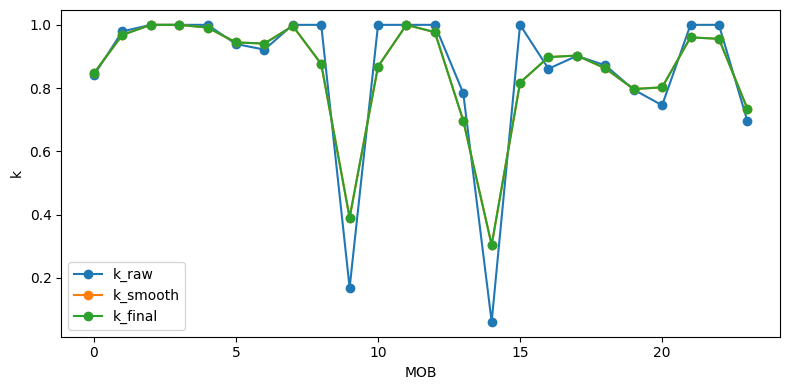

c:\Users\User\Projection_PB\Projection_pb\src\rollrate\calibration_kmob.py:847: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,mob,mae_adj,mae_markov
0,1,0.000303,0.000328
1,2,0.001566,0.001638
2,3,0.002947,0.002947
3,4,0.004866,0.004866
4,5,0.003911,0.003931
5,6,0.002605,0.002596
6,7,0.002657,0.002800
7,8,0.004980,0.004980
8,9,0.005413,0.005131
9,10,0.007941,0.005603


In [22]:
# Diagnostics
if k_raw_by_mob:
    plot_k_curves(k_raw_by_mob, k_smooth_by_mob, k_final_by_mob)

err_by_mob = backtest_error_by_mob(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    k_by_mob=k_final_by_mob,
    include_co=True,
    denom_mode="disb",
    disb_total_by_vintage=disb_total_by_vintage_fit,
    min_disb=1e-10,
    weight_mode="equal",
)

err_by_mob


# 7. Seasonality (option – nếu bạn dùng)

In [23]:
# # 7.1. Lấy actual sau calib (hoặc actual trước calib, tuỳ triết lý)
# df_actual_for_season = df_lifecycle_calib[df_lifecycle_calib["IS_FORECAST"] == 0].copy()

# # 7.2. Build seasonality (theo PRODUCT_TYPE × tháng VINTAGE)
# seasonality = build_seasonality(df_actual_for_season, smooth_window=3)

# # 7.3. Áp seasonality cho lifecycle (calib + forecast)
# df_lifecycle_final = apply_seasonality_to_lifecycle(
#     df_lifecycle_calib, seasonality
# )


In [24]:
# df_lifecycle_final da duoc tao o cac cell truoc


# 8. Sale plan: forecast, k-calib, seasonality

## 8.1. Load sale plan và forecast lifecycle theo MOB

In [25]:
# Sale plan section skipped


## 8.2. Áp k & seasonality cho sale plan

In [26]:
# Sale plan section skipped


# 9. Aggregate lên product / portfolio

## 9.1. Từ cohort nhỏ (Product × Score × Vintage × MOB) → lên Product × Vintage × MOB

In [27]:
# Lifecycle history (calibrated + forecast)
df_prod_hist = aggregate_to_product(df_lifecycle_final)

df_prod_hist


,index,PRODUCT_TYPE,VINTAGE_DATE,MOB,IS_FORECAST,DEL30_PCT,DEL60_PCT,DEL90_PCT,PRODUCT_DISB
0,0,A,2023-01-01,6,0,0.131230,0.099640,0.071702,1.585337e+11
1,1,A,2023-01-01,7,0,0.147494,0.120073,0.092150,1.585337e+11
2,2,A,2023-01-01,8,0,0.161826,0.132627,0.111875,1.585337e+11
3,3,A,2023-01-01,9,0,0.174697,0.148548,0.125384,1.585337e+11
4,4,A,2023-01-01,10,0,0.190737,0.161239,0.142568,1.585337e+11
...,...,...,...,...,...,...,...,...,...
1307,1307,A,2025-12-01,32,1,0.339040,0.322240,0.310978,4.251736e+11
1308,1308,A,2025-12-01,33,1,0.344883,0.329136,0.318551,4.251736e+11
1309,1309,A,2025-12-01,34,1,0.350337,0.335592,0.325663,4.251736e+11
1310,1310,A,2025-12-01,35,1,0.355427,0.341631,0.332329,4.251736e+11


## 9.2. Gộp nhiều product thành portfolio

In [28]:
portfolio_filter = ["CDLPIL", "SALPIL", "SPLPIL", "TOPUP", "TWLPIL", "XSELL"]

df_portfolio_hist = aggregate_products_to_portfolio(
    df_del_prod=df_prod_hist,
    portfolio_name="TOTAL_PIL",
    product_filter=portfolio_filter,
)


In [29]:
df_export = pd.concat([
    df_prod_hist,
    df_portfolio_hist,
], ignore_index=True)


In [30]:
# Lifecycle history (regularized k)
df_prod_hist_reg = aggregate_to_product(df_lifecycle_reg)

df_portfolio_hist_reg = aggregate_products_to_portfolio(
    df_del_prod=df_prod_hist_reg,
    portfolio_name="TOTAL_PIL",
    product_filter=portfolio_filter,
)

df_export_reg = pd.concat(
    [df_prod_hist_reg, df_portfolio_hist_reg],
    ignore_index=True,
)


In [31]:
actual_info_prod = (
    df_raw.groupby(["PRODUCT_TYPE", CFG["orig_date"]])["MOB"]
    .max()
    .to_dict()
)

actual_info_all = extend_actual_info_with_portfolio(
    actual_info_prod,
    portfolio_name="TOTAL_PIL",
)

try:
    export_lifecycle_all_products_one_file(
        df_del_prod=df_export,
        actual_info=actual_info_all,
        filename="lifecycle_calibrated_ETB.xlsx",
    )
except PermissionError as e:
    print("Skip export (file locked):", e)
try:
    export_lifecycle_all_products_one_file(
        df_del_prod=df_export_reg,
        actual_info=actual_info_all,
        filename="lifecycle_calibrated_reg_ETB.xlsx",
    )
except PermissionError as e:
    print("Skip export (file locked):", e)


✔ Export lifecycle multi-product thành công → lifecycle_calibrated_ETB.xlsx
✔ Export lifecycle multi-product thành công → lifecycle_calibrated_reg_ETB.xlsx


# 10. Export Excel 